### Minh Vo
### ADSP 32018 - Natural Language Processing and Cognitive Computing (Autumn 23)
### FINAL PROJECT

### Data Preprocessing & Cleaning

In [1]:
# !pip install pandarallel
# !pip install nltk
# !pip install textblob
# !pip install spacy
# !pip install google-cloud-storage

In [2]:
import time
import math
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from google.cloud import storage
import os

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')


import spacy
from spacy import displacy

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('once')
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 96


In [4]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)
workers=num_processors

INFO: Pandarallel will run on 95 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### News Data Loading

In [5]:
%%time

news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet'
news_df_final = pd.read_parquet(news_path, engine = 'pyarrow')

print(f'Data contains {news_df_final.shape[0]:,.0f} news articles')
news_df_final.head(3)

Data contains 199,677 news articles
CPU times: user 6.66 s, sys: 4.59 s, total: 11.3 s
Wall time: 27 s


,url,date,language,title,text
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P..."
1,http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html,2021-07-05,en,"Observation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef","\n\nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef\n\n \nHome |\nNASA Watch\nSpaceRef Business\nAstrobiology Web\nAdvertising\nAdd an Event\nSign up for our Daily Newsletter \n\n \n\n\nInternational Space Station\nNASA Hack Space\nCalendar\nMissions\nSpace Weather \n \n \nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe\n\n\n Press Release - Source: NATIONAL INSTITUTES OF NATURAL SCIENCES..."
2,http://usweekly.com/news/17/40964/Artificial-intelligence-yields-new-antibiotic.html,2020-02-23,en,Artificial intelligence yields new antibiotic - USweekly,"\n\n\nArtificial intelligence yields new antibiotic - USweekly\n﻿Sunday, 23 February 2020\nSend search form\n \n\nTodays news\nWorld\nU.S. National\nPolitics\nBusiness\nTechnology\nSports\nEntertainment\nBeauty & Health\nLiving & Travel\nScience\nWeather\nOdd news\nShopping\n\n \n\n\nArtificial intelligence yields new antibiotic\nAdded: 21.02.2020 21:19 | 35 views | 0 comments\nSource: www.slideshare.netUsing a machine-learning algorithm, researchers have identified a powerful new antibiotic..."


In [6]:
news_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199677 entries, 0 to 199676
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   url       199677 non-null  object
 1   date      199677 non-null  object
 2   language  199677 non-null  object
 3   title     199677 non-null  object
 4   text      199677 non-null  object
dtypes: object(5)
memory usage: 7.6+ MB


In [7]:
news_df_final.isna().sum()

url         0
date        0
language    0
title       0
text        0
dtype: int64

#### EDA

##### Top News Sources

In [8]:
# extract the domain names (news sources) from the URLs
from urllib.parse import urlparse

def extract_domain_from_url(url):
    parsed_url = urlparse(url)
    domain_parts = parsed_url.netloc.split('.')
    
    if len(domain_parts) > 1 and domain_parts[0] == 'www':
        return domain_parts[1]
    else:
        return domain_parts[0]

news_df_final2 = news_df_final.copy()
news_df_final2['domain'] = news_df_final2['url'].apply(extract_domain_from_url)
news_df_final2[['url', 'domain']].head()

,url,domain
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,galusaustralis
1,http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html,spaceref
2,http://usweekly.com/news/17/40964/Artificial-intelligence-yields-new-antibiotic.html,usweekly
3,http://www.dataweek.co.za/12835r,dataweek
4,http://www.huewire.com/how-you-should-validate-machine-learning-models-by-patryk-miziula-phd-jul-2023/,huewire


In [9]:
news_df_final2.domain.value_counts().head(20)

prnewswire           3966
einpresswire         2369
newsbreak            2268
citylife             2020
forbes               1922
venturebeat          1681
wfmz                 1400
producthunt          1396
nasdaq               1395
finance              1182
finanznachrichten    1146
globenewswire        1087
dailymail            1036
exbulletin            901
mccourier             862
bisouv                814
murphyshockeylaw      788
breakinglatest        751
news                  720
thehindu              704
Name: domain, dtype: int64

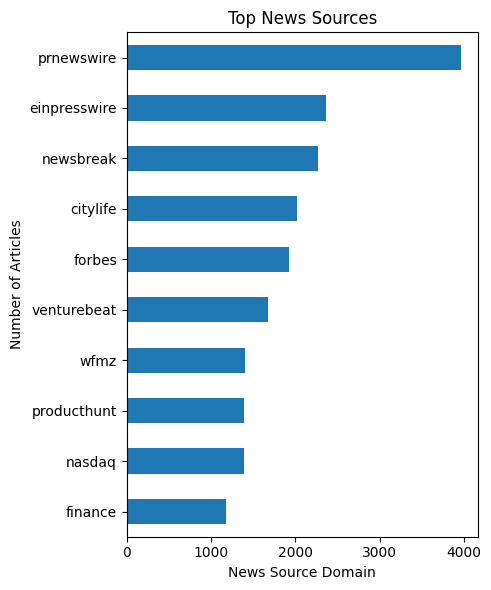

In [10]:
# Get the top news sources
top_news_sources = news_df_final2['domain'].value_counts().head(10)
top_news_sources = top_news_sources.sort_values()

plt.figure(figsize=(5,6))
top_news_sources.plot(kind='barh')
plt.xlabel('News Source Domain')
plt.ylabel('Number of Articles')
plt.title('Top News Sources')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

##### News Distribution Over Time

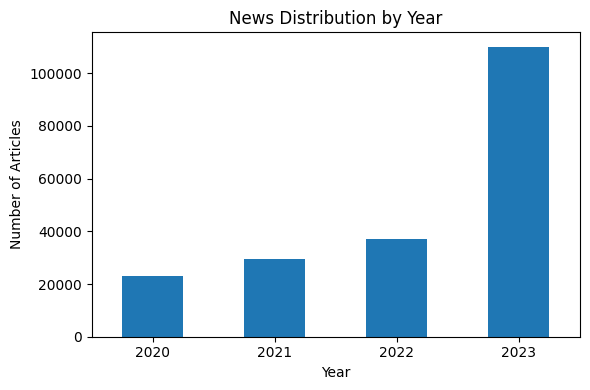

In [11]:
# Convert the 'date' column to a datetime data type
news_df_final2['date'] = pd.to_datetime(news_df_final2['date'])

# Extract year and month from the 'date' column
news_df_final2['year'] = news_df_final2['date'].dt.year
news_df_final2['month'] = news_df_final2['date'].dt.month

# Plot news distribution by year
plt.figure(figsize=(6,4))
news_df_final2['year'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('News Distribution by Year')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

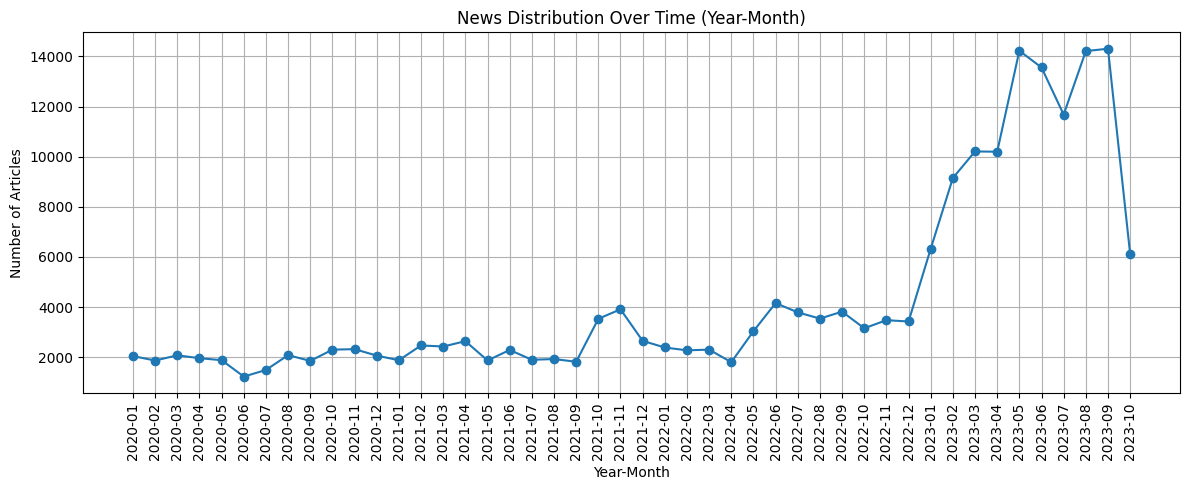

In [12]:
# Group by year and month, and count the number of articles in each group
news_distribution = news_df_final2.groupby(['year', 'month']).size().reset_index(name='count')
# Combine year and month into a single column for plotting
news_distribution['year_month'] = news_distribution['year'].astype(str) + '-' + news_distribution['month'].astype(str).str.zfill(2)

plt.figure(figsize=(12,5))
plt.plot(news_distribution['year_month'], news_distribution['count'], marker='o', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel('Number of Articles')
plt.title('News Distribution Over Time (Year-Month)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Clean News Data

In [13]:
news_df_final['language'].unique()

array(['en'], dtype=object)

In [14]:
# Extract articles in english language
news_eng = news_df_final[news_df_final['language'] == 'en']
news_eng.sample(n = 3, random_state = 42)

,url,date,language,title,text
56528,https://www.coursera.org/lecture/ai-for-everyone/week-4-introduction-CSHbd,2022-05-29,en,Week 4 Introduction - AI and Society | Coursera,"Week 4 Introduction - AI and Society | Coursera\n ExploreOnline DegreesFind your New CareerFor EnterpriseFor UniversitiesBrowseTop CoursesLog InJoin for FreeListWeek 4 IntroductionLoading...AI For EveryoneDeepLearning.AIFilled StarFilled StarFilled StarFilled StarFilled Star4.8 (36,026 ratings) | 780K Students EnrolledEnroll for FreeThis CourseVideo TranscriptAI is not only for engineers. If you want your organization to become better at using AI, this is the course to tell everyone--especia..."
69027,https://www.topbuzztrends.com/the-aging-of-disney-princesses-exploring-the-impact-of-artificial-intelligence/,2023-09-14,en,The Aging of Disney Princesses: Exploring the Impact of Artificial Intelligence - Top Buzz Trends,\nThe Aging of Disney Princesses: Exploring the Impact of Artificial Intelligence - Top Buzz Trends\n\n \n\n \n \nNo Result \n\n View All Result \n \n \n\n \n \nEntertainment\nBusiness\nGaming\n\nTech\n\nCrypto\nMore\n\nNetflix\n\nAmazon Prime\n\nMax\n\nCelebrity News\nMovies\nTV Shows\nParamount+\nDisney+\n\nHulu\nApple TV\nGoogle TV\nPolitics\nSports\n \n\nEntertainment\nBusiness\nGaming\n\nTech\n\nCrypto\nMore\n\nNetflix\n\nAmazon Prime\n\nMax\n\nCelebrity News\nMovies\nTV Shows\nPa...
29208,https://www.artnews.com/art-news/news/ai-white-house-artists-automation-karla-ortiz-1234655354/,2023-01-26,en,Policymakers in D.C. Don’t Appear To Be Focused On Artists’ AI Concerns – ARTnews.com,\nPolicymakers in D.C. Don’t Appear To Be Focused On Artists’ AI Concerns – ARTnews.com\n \n\n \n \n \n \n\n \n\n\n \n\n\t\t\tSkip to main content\t\t\n\n\tFollow Us\n\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\n\n\tNewsletters\n\n\nPlus Icon\nClick to Expand Search Input\n ARTnews\n\tEst. 1902\n\tSubscribe\n\tTO ART IN AMERICA\n\nPlus Icon\nClick to expand the Mega Menu\n\n\tNews\n\t\n\n\tMarket\n\t\n\n...


Clean-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text

In [15]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [16]:
def clean_news_text(text):
    # Convert text to lowercase
    cleaned_text = text.lower()
    
    # Remove URL
    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', str(cleaned_text))
    
    # Remove emails
    cleaned_text = re.sub(r'\S*@\S*\s?', '', str(cleaned_text))
    
    # Remove newline characters and tab characters
    cleaned_text = re.sub(r'[\n\t]', ' ', cleaned_text)
    
    # Remove number
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    
    # Remove punctuation
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    
    # Remove characters other than words (whitespace, underscore, etc)
    cleaned_text = re.sub(r'[^\w\s]|_', '', cleaned_text)
    
    # Preserve words with hyphens and underscores
    # Remove other special characters
    cleaned_text = re.sub(r'[^\w\s-]', '', cleaned_text)
    
    # Remove multiple spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    # Remove stopwords
    cleaned_text = " ".join([word for word in cleaned_text.split() if word not in stopwords])
    
    # Remove words longer than 14 characters
    cleaned_text = ' '.join([word for word in cleaned_text.split() if len(word) < 14])

    return cleaned_text

In [17]:
# Applying cleaning & tokenizing functions to both news' title and text
pandarallel.initialize()

news_eng["cleaned_title"] = news_eng["title"].parallel_apply(clean_news_text)
news_eng["cleaned_text"] = news_eng["text"].parallel_apply(clean_news_text)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


News Title

In [18]:
news_eng[["title","cleaned_title"]].sample(n = 5, random_state = 42)

,title,cleaned_title
56528,Week 4 Introduction - AI and Society | Coursera,week introduction ai society coursera
69027,The Aging of Disney Princesses: Exploring the Impact of Artificial Intelligence - Top Buzz Trends,aging disney princesses exploring impact artificial intelligence top buzz trends
29208,Policymakers in D.C. Don’t Appear To Be Focused On Artists’ AI Concerns – ARTnews.com,policymakers dc dont appear focused artists ai concerns artnewscom
44287,"Our AI future: heaven, hell, hype and hogwash",ai future heaven hell hype hogwash
65519,"bne IntelliNews - Bulgaria to develop AI research centre in partnership with Google, AWS",bne intellinews bulgaria develop ai research centre partnership google aws


News Text

In [19]:
news_eng[["text","cleaned_text"]].sample(n = 5, random_state = 42)

,text,cleaned_text
56528,"Week 4 Introduction - AI and Society | Coursera\n ExploreOnline DegreesFind your New CareerFor EnterpriseFor UniversitiesBrowseTop CoursesLog InJoin for FreeListWeek 4 IntroductionLoading...AI For EveryoneDeepLearning.AIFilled StarFilled StarFilled StarFilled StarFilled Star4.8 (36,026 ratings) | 780K Students EnrolledEnroll for FreeThis CourseVideo TranscriptAI is not only for engineers. If you want your organization to become better at using AI, this is the course to tell everyone--especia...",week introduction ai society coursera exploreonline degreesfind new careerfor enterprisefor courseslog injoin freelistweek starfilled starfilled starfilled starfilled star ratings k students freethis coursevideo transcriptai engineers want organization become better using ai course tell nontechnical colleaguesto take course learn meaning behind common ai terminology including neural networks machine learning deep learning data science ai realistically canand cannotdo spot opportunities apply...
69027,\nThe Aging of Disney Princesses: Exploring the Impact of Artificial Intelligence - Top Buzz Trends\n\n \n\n \n \nNo Result \n\n View All Result \n \n \n\n \n \nEntertainment\nBusiness\nGaming\n\nTech\n\nCrypto\nMore\n\nNetflix\n\nAmazon Prime\n\nMax\n\nCelebrity News\nMovies\nTV Shows\nParamount+\nDisney+\n\nHulu\nApple TV\nGoogle TV\nPolitics\nSports\n \n\nEntertainment\nBusiness\nGaming\n\nTech\n\nCrypto\nMore\n\nNetflix\n\nAmazon Prime\n\nMax\n\nCelebrity News\nMovies\nTV Shows\nPa...,aging disney princesses exploring impact artificial intelligence top buzz trends result view result entertainment business gaming tech crypto netflix amazon prime max celebrity news movies tv shows paramount disney hulu apple tv google tv politics sports entertainment business gaming tech crypto netflix amazon prime max celebrity news movies tv shows paramount disney hulu apple tv google tv politics sports result view result entertainment business gaming tech crypto home entertainment aging ...
29208,\nPolicymakers in D.C. Don’t Appear To Be Focused On Artists’ AI Concerns – ARTnews.com\n \n\n \n \n \n \n\n \n\n\n \n\n\t\t\tSkip to main content\t\t\n\n\tFollow Us\n\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\n\n\tNewsletters\n\n\nPlus Icon\nClick to Expand Search Input\n ARTnews\n\tEst. 1902\n\tSubscribe\n\tTO ART IN AMERICA\n\nPlus Icon\nClick to expand the Mega Menu\n\n\tNews\n\t\n\n\tMarket\n\t\n\n...,policymakers dc dont appear focused artists ai concerns artnewscom skip main content follow us icon link plus icon icon link plus icon icon link plus icon icon link plus icon icon link plus icon icon link plus icon newsletters plus icon click expand search input artnews est subscribe art america plus icon click expand mega menu news market artists artnews recommends top collectors travel artnews art america plus icon click expand mega menu menu read next adrian burrell explores difficultyand...
44287,"\n\nOur AI future: heaven, hell, hype and hogwash\n\n \n\n \n\n \n\n\t\t\tClose\t\t\n\nAccount\nSign In/Register\nSign In \n\n\nSearch for:\n \n\t\t\tSearch\t\t\nLatest\nPopular\nNewsletters\nPodcasts\n \n\nFacebook\nInstagram\nTwitter\n \n\nMy Account\n\nSearch\nLatestPopular\n\nNewsCultureArtsComedyScience\n\nFeatures:\nStrange CustomsParentingTABOOSecular SymphonyThe Color Of Disbelief\nAudio:\nPodcastsOn The Go ArticlesAdd Your Voice\n\nNewslettersWriter Alerts\n\nAbout Us\nOur Contribut...",ai future heaven hell hype hogwash close account sign inregister sign search search latest popular newsletters podcasts facebook instagram twitter account search latestpopular features strange symphonythe color disbelief audio podcastson go articlesadd voice alerts us inspiredhelp support onlysky close account search latestpopular features strange symphonythe color disbelief audio podcastson go articlesadd voice alerts us inspiredhelp support onlysky skip

Since news title are also included in news text, I will only use news text for future analysis.

In [20]:
# list of web remnants words
remove_words = [
    'AdBlock', 'Ad', 'Refresh', 'page', 'Search', 'Login', 'Register', 'Subscribe', 'Advertisement', 'Sponsored', 'Recommended', 'Read more', 'Read Next', 'Related Articles',
    'You may also like', 'Recommended for you', 'Join us', 'All rights reserved', 'Leave a comment', 'Privacy rights', 'Follow us', 'Follow on', 'Follow me', 'Followers',
    'Followed by', 'Followed by', 'Likes', 'Liked by', 'Retweets', 'Retweeted by', 'Reply', 'Retweet', 'Replying to', 'Twitter', 'Facebook', 'LinkedIn', 'Share', 'Shares', 
    'Comment(s)','Comments', 'Comment', 'Save', 'Bookmark', 'Download', 'Print', 'Email', 'More from', 'Latest News', 'Breaking News', 'Subscribe now', 'Sign up', 'Sign in',
    'Sign out', 'Sign in with', 'Login with', 'Create account', 'Forgot password', 'Privacy policy', 'Terms of service', 'Contact us', 'About us', 'Our team', 'Newsletter', 
    'Our story', 'Advertise with us', 'Work with us', 'Jobs at', 'Careers at', 'Powered by', 'Content by', 'Supported by', 'Made by', 'Designed by',
    'Developed by', 'Copyright', '©', 'http', 'https', 'www', 'com', 'net', 'org', 'edu', 'gov', 'info', 'biz', 'co', 'uk', 'us', 'ca', 'au', 'io', 'html', 'php',
    'aspx', 'jsp', 'xml', 'jpg', 'png', 'gif', 'pdf', 'doc', 'ppt', 'xls', 'mp3', 'avi', 'mp4', 'mov', 'swf', 'js', 'css', '404', '403', '500', '503', 'error',
    'click', 'here', 'click here', 'home', 'skip', 'link', 'icon', 'menu', 'expand', 'collapse', 'plus', 'browse'
]

In [21]:
# Remove specified web remnants words from the text.
def remove_web_remnants(text):
    # Tokenize the text into words
    words = text.split()

    # Remove web remnants words from the list of words (case-insensitive)
    filtered_words = [word for word in words if word.lower() not in set(word.lower() for word in remove_words)]

    # Rejoin the filtered words into a cleaned text
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

In [22]:
pandarallel.initialize()

news_eng["cleaned_title"] = news_eng["cleaned_title"].parallel_apply(remove_web_remnants)
news_eng["cleaned_text"] = news_eng["cleaned_text"].parallel_apply(remove_web_remnants)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [23]:
news_eng.sample(n = 3, random_state = 42)

,url,date,language,title,text,cleaned_title,cleaned_text
56528,https://www.coursera.org/lecture/ai-for-everyone/week-4-introduction-CSHbd,2022-05-29,en,Week 4 Introduction - AI and Society | Coursera,"Week 4 Introduction - AI and Society | Coursera\n ExploreOnline DegreesFind your New CareerFor EnterpriseFor UniversitiesBrowseTop CoursesLog InJoin for FreeListWeek 4 IntroductionLoading...AI For EveryoneDeepLearning.AIFilled StarFilled StarFilled StarFilled StarFilled Star4.8 (36,026 ratings) | 780K Students EnrolledEnroll for FreeThis CourseVideo TranscriptAI is not only for engineers. If you want your organization to become better at using AI, this is the course to tell everyone--especia...",week introduction ai society coursera,week introduction ai society coursera exploreonline degreesfind new careerfor enterprisefor courseslog injoin freelistweek starfilled starfilled starfilled starfilled star ratings k students freethis coursevideo transcriptai engineers want organization become better using ai course tell nontechnical colleaguesto take course learn meaning behind common ai terminology including neural networks machine learning deep learning data science ai realistically canand cannotdo spot opportunities apply...
69027,https://www.topbuzztrends.com/the-aging-of-disney-princesses-exploring-the-impact-of-artificial-intelligence/,2023-09-14,en,The Aging of Disney Princesses: Exploring the Impact of Artificial Intelligence - Top Buzz Trends,\nThe Aging of Disney Princesses: Exploring the Impact of Artificial Intelligence - Top Buzz Trends\n\n \n\n \n \nNo Result \n\n View All Result \n \n \n\n \n \nEntertainment\nBusiness\nGaming\n\nTech\n\nCrypto\nMore\n\nNetflix\n\nAmazon Prime\n\nMax\n\nCelebrity News\nMovies\nTV Shows\nParamount+\nDisney+\n\nHulu\nApple TV\nGoogle TV\nPolitics\nSports\n \n\nEntertainment\nBusiness\nGaming\n\nTech\n\nCrypto\nMore\n\nNetflix\n\nAmazon Prime\n\nMax\n\nCelebrity News\nMovies\nTV Shows\nPa...,aging disney princesses exploring impact artificial intelligence top buzz trends,aging disney princesses exploring impact artificial intelligence top buzz trends result view result entertainment business gaming tech crypto netflix amazon prime max celebrity news movies tv shows paramount disney hulu apple tv google tv politics sports entertainment business gaming tech crypto netflix amazon prime max celebrity news movies tv shows paramount disney hulu apple tv google tv politics sports result view result entertainment business gaming tech crypto entertainment aging disne...
29208,https://www.artnews.com/art-news/news/ai-white-house-artists-automation-karla-ortiz-1234655354/,2023-01-26,en,Policymakers in D.C. Don’t Appear To Be Focused On Artists’ AI Concerns – ARTnews.com,\nPolicymakers in D.C. Don’t Appear To Be Focused On Artists’ AI Concerns – ARTnews.com\n \n\n \n \n \n \n\n \n\n\n \n\n\t\t\tSkip to main content\t\t\n\n\tFollow Us\n\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\nIcon Link\nPlus Icon\n\n\tNewsletters\n\n\nPlus Icon\nClick to Expand Search Input\n ARTnews\n\tEst. 1902\n\tSubscribe\n\tTO ART IN AMERICA\n\nPlus Icon\nClick to expand the Mega Menu\n\n\tNews\n\t\n\n\tMarket\n\t\n\n...,policymakers dc dont appear focused artists ai concerns artnewscom,policymakers dc dont appear focused artists ai concerns artnewscom main content follow newsletters input artnews est art america mega news market artists artnews recommends top collectors travel artnews art america mega read next adrian burrell explores difficultyand promiseof escaping black american history artnews art america input artnews news policymakers dc dont appear focused artists artificial intelligence concerns shanti escalantede mattei shanti escalantede mattei stories shanti vie...


#### Detect Duplicated Articles

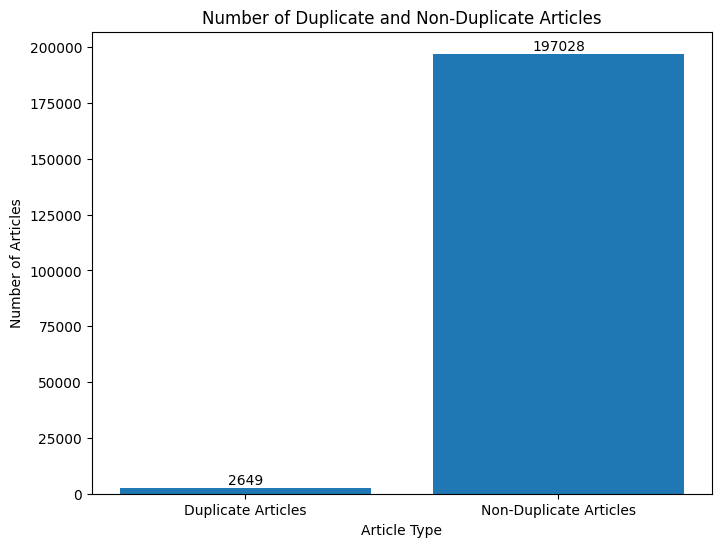

In [24]:
# Detect duplicate articles based on the 'cleaned_text' column
duplicates = news_eng[news_eng.duplicated(subset='cleaned_text', keep=False)]

# Get non-duplicated articles
non_duplicates = news_eng.drop_duplicates(subset='cleaned_text', keep=False)

# Count the number of duplicates and non-duplicates
num_duplicates = len(duplicates)
num_non_duplicates = len(non_duplicates)

# Create a bar plot to visualize the counts
plt.figure(figsize=(8, 6))
plt.bar(['Duplicate Articles', 'Non-Duplicate Articles'], [num_duplicates, num_non_duplicates])
plt.xlabel('Article Type')
plt.ylabel('Number of Articles')
plt.title('Number of Duplicate and Non-Duplicate Articles')

# Display the numbers on the plot
for i, count in enumerate([num_duplicates, num_non_duplicates]):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [25]:
duplicates = non_duplicates['cleaned_text'].duplicated()
duplicate_count = duplicates.value_counts()
print(duplicate_count)

False    197028
Name: cleaned_text, dtype: int64


In [26]:
#gsutil mb -l us-east1 gs://<minhvo-nlp-final>

In [27]:
# non_duplicates.to_parquet('cleaned_non_duplicate_data.parquet')

# bucket_name = 'minhvo-nlp-final'
# file_path = 'cleaned_non_duplicate_data.parquet'

# storage_client = storage.Client()
# bucket = storage_client.get_bucket(bucket_name)
# blob = bucket.blob(file_path)
# blob.upload_from_filename(file_path)

cleaned_non_duplicates_df = non_duplicates.copy()

In [28]:
cleaned_non_duplicates_df = pd.read_parquet('cleaned_non_duplicate_data.parquet', engine = 'pyarrow')

In [29]:
print(cleaned_non_duplicates_df.shape)
cleaned_non_duplicates_df.head(2)

(197028, 7)


,url,date,language,title,text,cleaned_title,cleaned_text
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...",legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis,legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis galus australis wednesday february trending needle counters market comprehensive study companies medline industries boen healthcare skin scrub trays market comprehensive study companies medline industries bd deroyal global portable handheld electronic game machine market outlook business insights apollo games sony aristocrat leisure igt infectious dise...
1,http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html,2021-07-05,en,"Observation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef","\n\nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef\n\n \nHome |\nNASA Watch\nSpaceRef Business\nAstrobiology Web\nAdvertising\nAdd an Event\nSign up for our Daily Newsletter \n\n \n\n\nInternational Space Station\nNASA Hack Space\nCalendar\nMissions\nSpace Weather \n \n \nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe\n\n\n Press Release - Source: NATIONAL INSTITUTES OF NATURAL SCIENCES...",observation simulation ai join forces reveal clear universe spaceref,observation simulation ai join forces reveal clear universe spaceref nasa watch spaceref business astrobiology web advertising add event sign daily international space station nasa hack space calendar missions space weather observation simulation ai join forces reveal clear universe press release source national institutes natural sciences posted july pm view using ai driven data analysis peel back noise find actual shape universe credit institute statistical mathematics japanese astronomers...


### Data Filtering

#### Discard Irrelevant Articles

In [30]:
key_words = ['data science', 'machine learning', 'artificial intelligence', 'ml', 'ai', 
             'natural language processing', 'reinforcement learning', 'computer vision', 'chatgpt']

In [31]:
# function to filter out irrelevant articles
def contains_keywords(text):
    for keyword in key_words:
        if keyword in text.lower():
            return True
    return False

In [32]:
# Count the number of articles that will be discarded
discarded_count = len(cleaned_non_duplicates_df) - len(cleaned_non_duplicates_df[cleaned_non_duplicates_df['cleaned_text'].apply(contains_keywords)])

# Apply the function to filter out irrelevant articles
cleaned_news_df2 = cleaned_non_duplicates_df[cleaned_non_duplicates_df['cleaned_text'].apply(contains_keywords)]
print(cleaned_news_df2.shape)

# Display the number of articles that will be discarded
print(f"Number of articles to be discarded: {discarded_count}")

(196851, 7)
Number of articles to be discarded: 177


#### News Articles' Length Distribution

In [33]:
cleaned_news_df2["text_word_count"] = cleaned_news_df2["cleaned_text"].apply(lambda x: len(str(x).split()))
cleaned_news_df2[["cleaned_text", "text_word_count"]].sample(n = 3, random_state = 42)

,cleaned_text,text_word_count
28902,things know may fbi new mexico shooting gas prices debt limit ai national wsiltvcom main content permission edit article edit close instagram site sign log dashboard logout account dashboard profile saved items logout news consumer watch crime courts tornado recovery health medical minute news morning politics illinois capitol news live streaming video wsiltv news app coronavirus shot local vaccine information coronavirus top stories weather weather project tornado closings delays submit clo...,974
71843,artificial intelligence hollywood offering actors frightening script quotes news mutual fund navstrending stockssuzlon energy ineh suzlon senco gold inew senco apple inea reliance microsoft hello loginhello loginloginor signupmy accountmy profile portfoliomy watchlistmy credit scoremy messagesmy alertsmy profile promy portfoliomy watchlistmy credit scoremy messagesmy usdownload appfollow indicesstock actionall statstop gainerstop losersonly buyersonly sellers week high week lowprice shockers...,1085
40120,usaf retracts claim ai drone killed operator sim jump navigation logincreate new form herehome dennis faas usaf retracts claim ai drone killed operator sim usaf retracts claim ai drone killed operator sim dennis faas june pm edt air force usaf official previously claimed air force conducted simulated test ai drone killed human operator retracting statement stating misspoke usafs chief ai test operations colonel tucker cinco hamilton clarified test described hypothetical thought experiment ra...,884


In [34]:
cleaned_news_df2.text_word_count.describe()

count    196851.000000
mean        769.724436
std         592.433790
min           3.000000
25%         457.000000
50%         635.000000
75%         939.000000
max       29413.000000
Name: text_word_count, dtype: float64

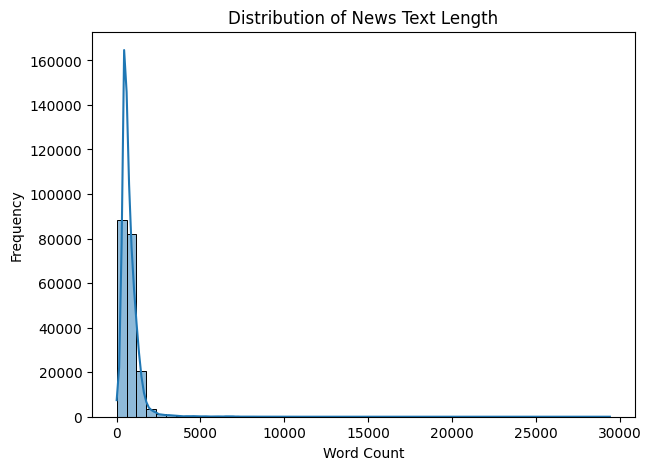

In [35]:
plt.figure(figsize=(7,5))
sns.histplot(data=cleaned_news_df2, x='text_word_count', bins=50, kde=True)
plt.title('Distribution of News Text Length')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

**Keeping articles with maximum 2500 words for analysis**

In [36]:
print(cleaned_news_df2[cleaned_news_df2['text_word_count'] <= 2500].shape)

(194333, 8)


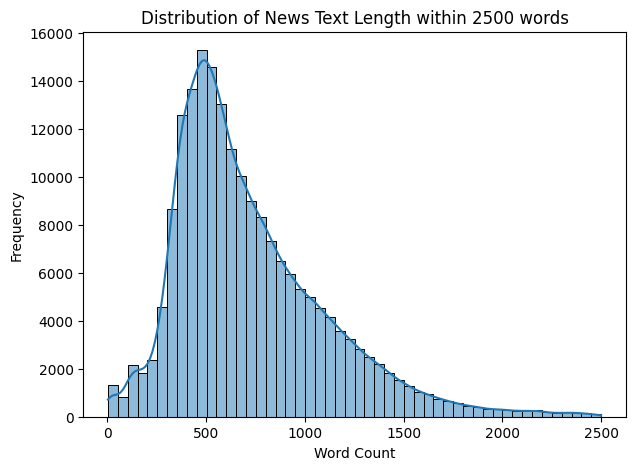

In [37]:
max_length_text = cleaned_news_df2[cleaned_news_df2['text_word_count'] <= 2500]

plt.figure(figsize=(7,5))
sns.histplot(data = max_length_text, x = 'text_word_count', bins=50, kde=True)
plt.title('Distribution of News Text Length within 2500 words')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [38]:
# Discard too short articles (under 120 words)
max_length_text = max_length_text[max_length_text['text_word_count'] > 120]
max_length_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191487 entries, 0 to 199676
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   url              191487 non-null  object
 1   date             191487 non-null  object
 2   language         191487 non-null  object
 3   title            191487 non-null  object
 4   text             191487 non-null  object
 5   cleaned_title    191487 non-null  object
 6   cleaned_text     191487 non-null  object
 7   text_word_count  191487 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 13.1+ MB


In [39]:
max_length_text.text_word_count.describe()

count    191487.000000
mean        734.331150
std         379.388738
min         121.000000
25%         462.000000
50%         636.000000
75%         928.000000
max        2500.000000
Name: text_word_count, dtype: float64

In [40]:
max_length_text.to_parquet("cleaned_news_df2.parquet")

bucket_name = 'minhvo-nlp-final'
file_path = 'cleaned_news_df2.parquet'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_path)
blob.upload_from_filename(file_path)

#### Text Standardization (using POS tagging and lemmatization)

In [41]:
cleaned_news_df2 = pd.read_parquet('cleaned_news_df2.parquet', engine = 'pyarrow')

In [42]:
print(cleaned_news_df2.shape)
cleaned_news_df2.head(2)

(191487, 8)


,url,date,language,title,text,cleaned_title,cleaned_text,text_word_count
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...",legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis,legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis galus australis wednesday february trending needle counters market comprehensive study companies medline industries boen healthcare skin scrub trays market comprehensive study companies medline industries bd deroyal global portable handheld electronic game machine market outlook business insights apollo games sony aristocrat leisure igt infectious dise...,666
1,http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html,2021-07-05,en,"Observation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef","\n\nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef\n\n \nHome |\nNASA Watch\nSpaceRef Business\nAstrobiology Web\nAdvertising\nAdd an Event\nSign up for our Daily Newsletter \n\n \n\n\nInternational Space Station\nNASA Hack Space\nCalendar\nMissions\nSpace Weather \n \n \nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe\n\n\n Press Release - Source: NATIONAL INSTITUTES OF NATURAL SCIENCES...",observation simulation ai join forces reveal clear universe spaceref,observation simulation ai join forces reveal clear universe spaceref nasa watch spaceref business astrobiology web advertising add event sign daily international space station nasa hack space calendar missions space weather observation simulation ai join forces reveal clear universe press release source national institutes natural sciences posted july pm view using ai driven data analysis peel back noise find actual shape universe credit institute statistical mathematics japanese astronomers...,587


In [43]:
# !python -m spacy download en_core_web_sm

In [44]:
# Load the SpaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def spacy_lemmatization(text):
    # Process the text with SpaCy
    doc = nlp(text)

    # Lemmatize and retain words of specific POS tags
    lemmatized_output = ' '.join([token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])
    
    return lemmatized_output

In [45]:
%%time
# Apply tokenization and lemmatization to the 'cleaned_title' and 'cleaned_text' columns
cleaned_news_df2['lemmatized_title'] = cleaned_news_df2['cleaned_title'].parallel_apply(spacy_lemmatization)
cleaned_news_df2['lemmatized_text'] = cleaned_news_df2['cleaned_text'].parallel_apply(spacy_lemmatization)

CPU times: user 3.17 s, sys: 19 s, total: 22.2 s
Wall time: 4min 34s


In [46]:
cleaned_news_df2[['title', 'cleaned_title', 'lemmatized_title', 'text', 'cleaned_text', 'lemmatized_text']].sample(n = 5, random_state = 42)

,title,cleaned_title,lemmatized_title,text,cleaned_text,lemmatized_text
151860,UK Government Warned for Lack of AI Transparency in Welfare Claims,government warned lack ai transparency welfare claims,government warn lack ai transparency welfare claim,"UK Government Warned for Lack of AI Transparency in Welfare Claims \n \n\nSkip to contentSun. Sep 3rd, 2023 CityLifeUnveiling New Technologies and the Power of AI\n \n\nAINewsSpaceTechnologySatelliteScienceU.S.Contact\n\n \nTechnology\n \nUK Government Warned for Lack of AI Transparency in Welfare Claims\n ByGabriel Botha\n\nSep 3, 2023\nThe UK government could face contempt of court charges if it fails to improve transparency surrounding its use of artificial intelligen...",government warned lack ai transparency welfare claims contentsun sep rd new technologies power ai technology government warned lack ai transparency welfare claims bygabriel botha sep government could face contempt court charges fails improve transparency surrounding use artificial intelligence ai welfare claim assessments department work pensions dwp increasingly relied ai detect fraud universal credit claims lack transparency criticized child poverty advocates particularly concerned potenti...,government warn lack ai transparency welfare claim rd new technology power ai technology government warn lack ai transparency welfare claim government face contempt court charge fail improve transparency surround use artificial intelligence ai welfare claim assessment department work pension dwp increasingly rely ai detect fraud universal credit claim lack transparency criticize child poverty advocate particularly concerned potential impact child benefit suspend base decision make informatio...
144258,AI and analytics leader SAS delivers trustworthy generative AI value through industry solutions,ai analytics leader sas delivers trustworthy generative ai value industry solutions,ai analytic leader deliver trustworthy generative ai value industry solution,AI and analytics leader SAS delivers trustworthy generative AI value through industry solutions\n\nSkip to contentAvera Medical MinuteLocal GuideSomeone You Should KnowTouchstone Energy Scholar of the WeekHomeWeatherSportsSubmit ItLivestreamLatest newscastsDelays and CancellationsHomeNewsAgricultureCrimeEconomyEducationEntertainmentInternationalNationalMaking A DifferenceRegionalScienceStateTechnologyLivestreamWeatherInteractive RadarSioux FallsNortheast SDCentral SDDelays and CancellationsS...,ai analytics leader sas delivers trustworthy generative ai value industry solutions contentavera medical minutelocal guidesomeone energy scholar radarsioux sdcentral sddelays networkmap roomroad weekplay weekpigskin previewstats election mapssouth dakota election mapsiowa election mapsminnesota election mapsmorningmr foodowning weekavera medical minutecontact usmeet teamcareers dakota news nowcareers graycommunity usag marketscovid updatescovid mapsomeone photos videogray dc country music re...,ai analytic leader deliver trustworthy generative ai value industry solution contentavera medical minutelocal guidesomeone energy scholar radarsioux sdcentral sddelay networkmap roomroad weekplay weekpigskin previewstat election election election mapsminnesota election mapsmorningmr foodowning weekavera medical minutecontact usmeet teamcareer news nowcareer photo videogray country music releasesai analytic leader deliver trustworthy generative value industry pm cdtupdate minute expand strate...
81326,Star Wars AI trailer 'directed by Wes Anderson' sparks fierce debate | Metro News,star wars ai trailer directed wes anderson sparks fierce debate metro news,star war ai trailer direct wes spark fierce debate,\n\nStar Wars AI trailer 'directed by Wes Anderson' sparks fierce debate | Metro News\n\n \nNEWS... BUT NOT AS YOU KNOW IT\n\n \n\nNews\nSport\n\nNews\n\nLondon\nUK\nUS\nWorld\nTech\nCoronation\nCost of living\nRussia-Ukraine\nWeird\n\n\nSport\n\nFootball\nPremier League\nTransfer News\nCr

**Save Final Data**

In [47]:
cleaned_news_df2.to_parquet('final_cleaned_news_df.parquet')

bucket_name = 'minhvo-nlp-final'
file_path = 'final_cleaned_news_df.parquet'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_path)
blob.upload_from_filename(file_path)